# First : A simple neuron

A single, vanilla neuron, takes some number of inputs, weights these inputs by some other number , sums the result, and finally produces an output by sending it through an **activation function** (e.g sigmoid) to get output y

$$y = sigmoid(W_1\cdot X_1 + W_2\cdot X_2 ... + W_n\cdot X_n)$$

In [165]:
import numpy as np

# Define the sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# The weights, assume there are 3 inputs for now
weights = np.array([0.5, 0.3, 0.8])

# The bias
bias = -0.3

# The inputs
inputs = np.array([1.0, 0.5, 2.0])

# TODO: Compute the linear combination of inputs, weights and bias
linear_combination = np.dot(inputs, weights) + bias

# TODO: Pass the linear combination through the sigmoid activation function
output = sigmoid(linear_combination)

# Print the output
print(output)


0.8754466418125836


# Now : Recurrent neurons

In the neuron above, the output depends solely on the current input and weights. This is fine when you have some input that doesn't have a time dimension. For example, if you're trying to get a decision - to buy or not to buy - a house based on some features (number of rooms, color, number of bathrooms etc.), there is there no 'time dependent' (i.e sequential) nature to your input data. One feature (number of rooms) is not the same as another (color) and is not depenendent on the feature that came before it. **Its easier to think of time as anything sequential**. There is no sequential relation in this example.

- One example of your dataset might look like : [3, red, 4, Buy] with the last column being the decision

However, now consider a different situation. Here, you want to predict the price of a house today based on the price of the house over the past 365 days. In this case, there is a **sequential** relationship between your features. That is, **each featuer is essentially identical but what differs is that they are measured a different times**. Most importantly though, we assume that **the system's current state**, at time $t$ (captured as a measurement at time $t$) is some how dependent on the **past states of the system**.

- One example might look like : [3.4,3.3,2.9,3.0...3] where this vector is of length 365

Suppose we want to use the first 364 days to predict the 365th day's price. How would we capture this with the neuron above? The neuron would have 364 weights, one for each day and we would try to predict some continuous value (instead of sending the weighted sum through a sigmoid, i.e just a linear regression). Then we'd compare it to the actual value on day 365 and update the weights based on how far off our prediction was from the actual price. 

$$\text{Price on day 365} = \text{activation}(W_1\cdot day_1 + W_2\cdot day_2 ... +  W_{364}\cdot  day_{364})$$ 

This presents two problems: 

1. Now, say we want to predict the 366th day. How would we incorporate the prediction we made for day 365? We wouldn't be able to use the neuron above because that only has 364 weights. We'd need a neuron with 365 weights. On and on, for every new day we want. It's the same problem if we started from the 200th day and wanted to predict the 201st, then the 202nd etc. This is problematic. You need a neuron with increasingly more weights for each time step. 

2. Most importantly though, **notice that each time step gets its own weight**. We are essentially treating each time step as a unique feature which is not what we want. Its the same feature, just measured at a different time. We want to **model the fact that the price on day 365 is actually influenced by the price at day 364**. That is, we want the weight for day 330 and 331 to be not treated as independent but for the weight for day 331 to be influenced by the weight for day 330. 

### Recurrence to the rescue.
Recurrence is a fancy word for "occurring again" and a recurrent neuron helps us solve these problems by **modelling the relationship between past and present as the sharing of weights between time steps** (i.e., our features). So instead of sending the entire 364 long vector into the one neuron at once, we will loop through this vector, sending the measurement at each time step into the neuron one at at time.

$$\text{output}_t  = \text{activation}(W_{\text{input}}\cdot x_t + W_\text{state} \cdot \text{output}_{t-1})$$

The magic happens with the weight $W_{state}$ which is used to scale the output at the previous step in the process of incorporating it into the current output. The modeling of the time dependent relationship is carried out with this weight because **it is shared between time steps** .

 Consider the situation where we just decide that this weight should be 0.5. Everytime a new output is generated, the 'impact' of the previous time step is scaled by this fixed value. However, recall the premise of this entire enterprise : we don't know what this value should be ,we want to learn this from the data (this applies to $W_{\text{input}}$ as well) 

Recall that somewhere down the line, we are comparing the values we generate at a specific time step to the actual value at that time step to calculate the error. As we train (**minimize this error**), $W_{\text{state}}$ and $W_{\text{input}}$ get updated. 


## A recurrent neuron

Our recurrent neuron looks something like this. No learning is being done here. This is akin to us arbitarily deciding on what the current input and previous output should be scaled by.

In [221]:
# We'll make this a class so we can use this later
class RNN:
    def __init__(self, input_size, output_size, hidden_dim=1):
            # We have the weight for the input at time t, say randomly initialized from a normal distribution
            self.W_input = np.random.normal(size=1)
            # We have the weight for the hidden state at time t, say randomly initialized from a normal distribution
            self.W_state = np.random.normal(size=1)
            # We have the bias term, say randomly initialized from a normal distribution
            self.b = np.random.normal(size=1)
            # We have the previous output, initialized to 0
            self.previous_output = 0
    # Let's use a relu activation function so the output is 0 or the linear combination, never gets negative which wouldn't
    # make sense for a house price
    def relu(self, x):
        return max(0, x)
    # The forward pass
    def forward(self, input):
        # loop through the inputs
        for input_t in input:
            # compute the linear combination
            linear_combination = self.W_input * input_t + self.W_state * self.previous_output + self.b
            # compute the output
            output = self.relu(linear_combination)
            # update the previous output
            self.previous_output = output
        # return the output
        return output

In [222]:
# Dummy input for a price of a house - just random values here for now.
house_price = np.random.normal(size=365, scale=100000)
# Initialize the RNN
rnn = RNN(input_size=1, output_size=1)
# Compute the output
output_final = rnn.forward(house_price)

# print the final output after all the iterations
print(output_final)

0


## Making it learn

Recall the learning process for a vanilla neuron, which would look like this:
$$\text{input} \rightarrow \text{weighted sum and get output} \leftrightarrow \text{calculate error and update weights}$$

It's the exact same process for RNNs but with a twist. At each time step, we predict an output which means at each time step, we have an error. This is the same as the error we would have for a vanilla neuron - for each example, we get an error which we use to update the weights (after each example or a batch of examples). 
- If **we update the weights after every time step**, then we are doing the same thing as updating a vanilla neuron after every training example. (Stochastic or online training)
- If we **update after processing the entire sequence**, this is the same thing as doing a batched update (i.e., updating the weights after one training batch or the entire training set) for the vanilla neuron. (batched training)
    

### Stochastic updates

For simplicity, let's implement the after-each-example verison of the weight updates. Let's update the RNN class. The changes are noted. We need to do the following
- Starting at the beginning of our vector, at each time step, predict the next time step
    - That is, if we're at day 330, we predict day 331 and our target value is the actual value for 331
    - In a vanilla fully connected neuron, the target would be some other value, not the next example in our dataset.
- Compare this prediction to the actual value for the next time step. 
    - Update the weights accordingly
    - $$W_{\text{input}} = W_{\text{input}} - \alpha\cdot\frac{\delta\text{loss}}{\delta W_{\text{input}}}$$
    - $$W_{\text{state}} = W_{\text{state}} - \alpha\cdot\frac{\delta\text{loss}}{\delta W_{\text{state}}}$$
    - $$b = b - \alpha\cdot\frac{\delta\text{loss}}{\delta b}$$

In [328]:
class RNN:
    def __init__(self, input_size, output_size, hidden_dim=1, learning_rate=0.001):
            # We have the weight for the input at time t, say randomly initialized from a normal distribution
            self.W_input = np.random.normal(size=1)
            # We have the weight for the hidden state at time t, say randomly initialized from a normal distribution
            self.W_state = np.random.normal(size=1)
            # We have the bias term, say randomly initialized from a normal| distribution
            self.b = np.random.normal(size=1)
            # We have the previous output, initialized to 0
            self.previous_output = 0
            # define the learning rate
            self.learning_rate = learning_rate
            # keep track of the linear combination
            self.linear_combination = 0
            # keep track of the average loss at each epoch
            self.losses = []
    # Let's use a relu activation function so the output is 0 or the linear combination, never gets negative which wouldn't
    # make sense for a house price
    def relu(self, x):
        return max(np.array([0]), x)
    ## -- CHANGED -- : Adding derivative of relu function
    def relu_derivative(self, x):
        if x > 0:
            return np.array([1])
        else:
            return np.array([0])
    ## -- CHANGED -- define mean squared error as our loss function
    def loss(self, target, output):
        return (target - output)**2
    ## -- CHANGED -- define the derivative of the loss function
    def loss_derivative(self, target, output):
        return -2*(target - output)
    # The forward pass
    def forward(self, input_t):
        # compute the linear combination
        ## -- CHANGED ---- : Update to use the values defined above. Save the linear combination for later use
        self.linear_combination = self.W_input * input_t + self.W_state * self.previous_output + self.b
        # compute the output
        output = self.relu(self.linear_combination)            
        # update the previous output
        self.previous_output = output
        # return the output
        return output
    def backward(self, input, target, output):
        ## -- CHANGED -- : Update weights and bias using gradient descent
        # compute the error
        error_derivative = self.loss_derivative(target, output)
        # gradient of the error with respect to the input
        gradient_W_input = error_derivative * self.relu_derivative(self.linear_combination) * input
        # gradient of the error with respect to the state
        gradient_W_state = error_derivative * self.relu_derivative(self.linear_combination) * self.previous_output
        # gradient of the error with respect to the bias
        gradient_bias = error_derivative * self.relu_derivative(self.linear_combination)
        
        # update the weights and bias
        self.W_input -= self.learning_rate * gradient_W_input
        self.W_state -= self.learning_rate * gradient_W_state
        self.b -= self.learning_rate * gradient_bias
    def train(self, input):
        # loop through the inputs
        # save all the input for BPTT
        self.all_inputs = input
        total_loss = 0
        ## -- CHANGED -- : We loop to the one before the last element instead of the whole input
        for time in range(len(input)-1):
            # the target is the next element
            target = input[time+1]
            # get the output for the current element
            output = self.forward(input[time])
            # update the weights and bias based on the prediction and the target.
            self.backward(input[time], target, output)
            # update the total loss
            total_loss += self.loss(target, output)
        avg_loss = total_loss / (len(input)-1)
        self.losses.append(avg_loss[0])
        return output

Let's test with a staright line with some noise

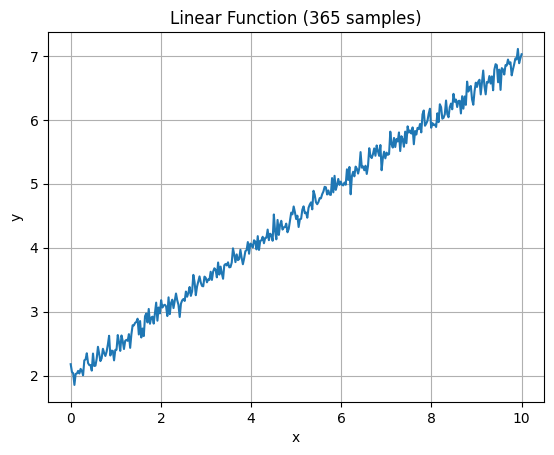

In [872]:
import numpy as np
import matplotlib.pyplot as plt

# Set the seed for reproducibility
np.random.seed(3)

# Generate 365 samples from a linear function over a specific range (e.g., 0 to 10)
x = np.linspace(0, 10, 365)
noise = np.random.normal(scale=0.1, size=365) 
y = 0.5 * x + 2 + noise

# Plot the generated linear function samples
plt.plot(x, y)
plt.title('Linear Function (365 samples)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


Epoch 0, Output: [22.66753362]
Epoch 10, Output: [11.64931786]
Epoch 20, Output: [9.68955524]
Epoch 30, Output: [8.73895053]
Epoch 40, Output: [8.16482802]
Epoch 50, Output: [7.78103079]
Epoch 60, Output: [7.50916332]
Epoch 70, Output: [7.30935987]
Epoch 80, Output: [7.15880219]
Epoch 90, Output: [7.04332567]


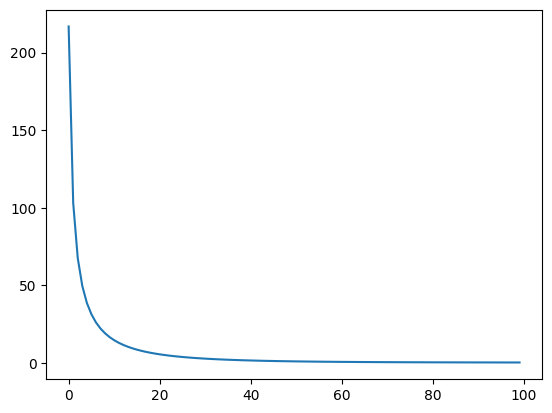

In [884]:
rnn = RNN(input_size=1, output_size=1, learning_rate=0.000001)
num_epochs = 100
for epoch in range(num_epochs):
    output = rnn.train(y)
    if epoch % 10 == 0:  # Print/plot every 10 epochs, for example
        print(f'Epoch {epoch}, Output: {output}')

# Plot the loss over the epochs
plt.plot(rnn.losses)

In [875]:
# Set a different seed for reproducibility
np.random.seed(1)
# Generate a new set of 365 samples from the linear function over a specific range (e.g., 0 to 10)
x_test = np.linspace(0, 10, 365)
# add some noise
noise = np.random.normal(scale=0.1, size=365) 
y_test = 0.5 * x_test + 2 + noise

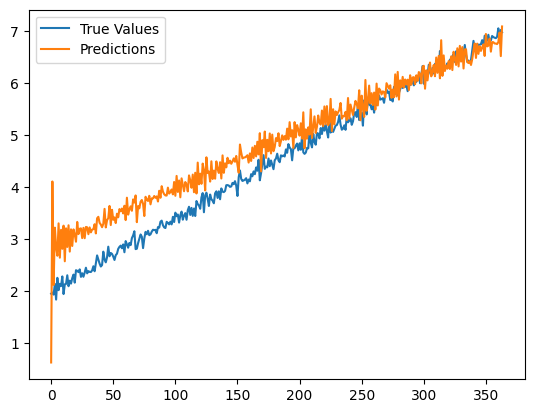

In [898]:
import matplotlib.pyplot as plt

# Send in one sample at a time to the RNN and record the output
predictions = [rnn.forward(y_test[i]) for i in range(len(y)-1)]

# start with the first value in the test set and predict the rest 
# (we can't predict the first value as we don't have the previous output)
# predictions = []
# #first_prediction = rnn.forward(y_test[0])
# for i in range(len(y_test)-1):
#     if i == 0:
#         predictions.append(rnn.forward(y_test[0]))
#     else:
#         predictions.append(rnn.forward())

plt.plot(y_test[1:], label='True Values')  # skip the first value as we start predicting from the second value
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()

### Updating afer processing the entire sequence (Back propagation through time BPTT)

In BPTT, we take all the losses calculated at each time step, like we did above, **accumulate them**, and update our weights ($W_{\text{input}}$ and $W_\text{state}$) with respect to this total loss  instead of at each time step.

Basically, before we change anything in the network, we check how well it (i.e., $W_{\text{input}}$ and $W_\text{state}$)) does on each time step (individual loss) and calculate a total loss from this. By minimizing this total loss, we're asking the network to **not just learn to do well on the current time step but do well on all the time steps**. This has the effect of **capturing long-term dependencies**. Put differently, if there is a long term pattern in the sequence but there is suddenly a lot of noise in a small section of the sequence, what would happen to a model that we update after each time step? It would capture this noise in its gradient updates. On the other hand, with BPTT, we focus more on the longer term trends. Because a model with BPTT considers the loss on the entire sequence before an update, it will not be impacted too much by this situation.

First, we need to update the forward pass and backward to collect some of the values we need from each timestep. We'll copy the previous implementation add on from there. We need to collect
1. All the inputs
2. All the targets
3. All the outputs 
4. All the linear combinations
5. All the gradients

In [877]:
class RNN_BPTT:
    def __init__(self, input_size, output_size, hidden_dim=1, learning_rate=0.001):
            # We have the weight for the input at time t, say randomly initialized from a normal distribution
            self.W_input = np.random.normal(size=1)
            # We have the weight for the hidden state at time t, say randomly initialized from a normal distribution
            self.W_state = np.random.normal(size=1)
            # We have the bias term, say randomly initialized from a normal| distribution
            self.b = np.random.normal(size=1)
            # We have the previous output, initialized to 0
            self.previous_output = 0
            # define the learning rate
            self.learning_rate = learning_rate
            # keep track of the linear combination
            self.linear_combination = 0
            # -- CHANGED -- collect the linear combinations for BPTT
            self.all_linear_combinations = []
            # keep track of the average loss at each epoch
            self.losses = []
    # Let's use a relu activation function so the output is 0 or the linear combination, never gets negative which wouldn't
    # make sense for a house price
    def relu(self, x):
        return max(np.array([0]), x)
    def relu_derivative(self, x):
        if x > 0:
            return np.array([1])
        else:
            return np.array([0])
    def loss(self, target, output):
        return (target - output)**2
    def loss_derivative(self, target, output):
        return -2*(target - output)
    # The forward pass 
    # the input is 0 by default so that we can auto-regressively predict the next element in the sequence
    # that is, suppose we want to predict the next element based on the previous prediction. If we use the previous prediction
    # again as an input, we are using the previous prediction twice in the linear combination calculation
    #  : once as an input and once as the previous output - these are the same thing. So we set the input to 0 by default
    # However, it does very poorly when we try to predict values this way for many reasons (e.g., accumulation of error)
    def forward(self, input_t = 0):
        # compute the linear combination
        self.linear_combination = self.W_input * input_t + self.W_state * self.previous_output + self.b
        # -- CHANGED -- save the linear combination for BPTT
        self.all_linear_combinations.append(self.linear_combination)
        # compute the output
        output = self.relu(self.linear_combination)            
        # update the previous output
        self.previous_output = output
        # return the output
        return output
    def backward(self):
        '''
        -- CHANGED --
        Backpropagation Through Time (BPTT).
        '''
        # total gradient of W_input 
        self.total_gradient_W_input = 0
        # total gradient of W_state
        self.total_gradient_W_state = 0
        # total gradient of bias
        self.total_gradient_bias = 0
        # loop through the inputs
        for time in range(len(self.all_inputs)-1):
            # get the linear combination for the current time step
            linear_combination = self.all_linear_combinations[time]
            # calculate the gradient of the loss with respect to the output at the current time step
            loss_derivative = self.loss_derivative(self.all_targets[time], self.all_outputs[time])

            # gradient of W_input
            gradient_W_input = loss_derivative * self.relu_derivative(linear_combination) * self.all_inputs[time]

            # gradient of W_state 
            if time > 0:
                gradient_W_state = loss_derivative * self.relu_derivative(linear_combination) * self.all_outputs[time - 1]
            else:
                gradient_W_state = loss_derivative * self.relu_derivative(linear_combination) * self.all_outputs[time]
            
            # gradient of bias
            gradient_bias = loss_derivative * self.relu_derivative(linear_combination)

            # update the total gradients
            self.total_gradient_W_input += gradient_W_input
            self.total_gradient_W_state += gradient_W_state
            self.total_gradient_bias += gradient_bias
        
        # update the weights and bias
        self.W_input -= self.learning_rate * self.total_gradient_W_input
        self.W_state -= self.learning_rate * self.total_gradient_W_state
        self.b -= self.learning_rate * self.total_gradient_bias
    def train(self, input):
        # loop through the inputs
        # --CHANGED-- save all the input for BPTT
        self.all_inputs = input
        # --CHANGED-- save all targets for BPTT
        self.all_targets = input[1:]
        # -- CHANGED -- collect the output at each time step for BPTT
        self.all_outputs = []

        total_loss = 0
        for time in range(len(input)-1):
            # the target is the next element
            target = input[time+1]
            # get the output for the current element
            output = self.forward(input[time])
            self.all_outputs.append(output)
            # update the total loss
            total_loss += self.loss(target, output)
        # --CHANGED -- update the weights and bias based on the prediction and the target by calling backward once per epoch
        self.backward()
        avg_loss = total_loss / (len(input)-1)
        self.losses.append(avg_loss)
        return self.all_outputs

Let's test it.

Epoch 0, Output: [array([1.29572762]), array([1.64487841]), array([1.74625117]), array([1.67256445]), array([1.74943166]), array([1.77786512]), array([1.81101963]), array([1.79798172]), array([1.83588028]), array([1.8308621]), array([1.78835142]), array([1.91113097]), array([1.95878289]), array([2.03068969]), array([1.96501366]), array([1.92516295]), array([1.91204629]), array([1.85729377]), array([1.99541785]), array([1.92643147]), array([1.90718202]), array([1.96623087]), array([2.09232017]), array([2.06819091]), array([1.99470249]), array([1.99707329]), array([2.08411258]), array([2.07442895]), array([2.04375426]), array([2.0733392]), array([2.14797182]), array([2.2521773]), array([2.10572942]), array([2.102385]), array([2.09896269]), array([2.01144482]), array([2.07851758]), array([2.10244704]), array([2.24381115]), array([2.22425744]), array([2.13875502]), array([2.25177215]), array([2.23781464]), array([2.16023654]), array([2.21014005]), array([2.23482428]), array([2.23418034]), 

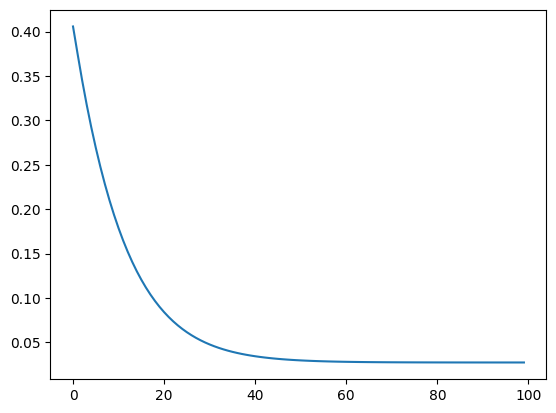

In [881]:
rnn = RNN_BPTT(input_size=1, output_size=1, learning_rate=0.000001)
num_epochs = 100
# normalize the data
for epoch in range(num_epochs):
    output = rnn.train(y)
    if epoch % 10 == 0:  # Print/plot every 10 epochs, for example
        print(f'Epoch {epoch}, Output: {output}')

# Plot the loss over the epochs
plt.plot(rnn.losses)

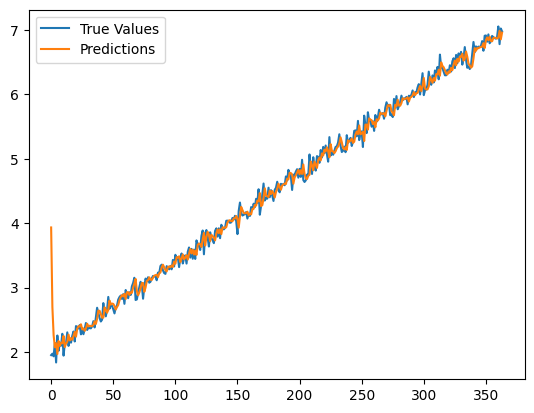

In [882]:
import matplotlib.pyplot as plt

# Send in one sample at a time to the RNN and record the output
predictions = [rnn.forward(y_test[i]) for i in range(len(y)-1)]

# start with the first value in the test set and predict the rest 
# (we can't predict the first value as we don't have the previous output)
# predictions = []
# #first_prediction = rnn.forward(y_test[0])
# for i in range(len(y_test)-1):
#     if i == 0:
#         predictions.append(rnn.forward(y_test[0]))
#     else:
#         predictions.append(rnn.forward())

plt.plot(y_test[1:], label='True Values')  # skip the first value as we start predicting from the second value
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()


### (some of the) Problems with this model
Note that this is a very simplistic model. It runs into many problems. 
- When you run the training process, sometimes these models gets stuck in a state where the outputs are all zeros.
    - This is a result of the ReLU activation function  (https://www.mygreatlearning.com/blog/relu-activation-function/)
- Even the BPTT model, which is actually able to predict the next value almost perfectly, fails when you try to make predictions in an auto-regressive manner (predict the next prediction from the previous prediction). Because there is some error in each prediction, these will accumulate and the model will go off in a wrong direction, unable to correct itself.
- Recall that we just have 1 weight for both the input scaling and the previous out-put scaling. This is severely limited but it served for the purposes of going through the steps of understanding whats happening

# Gated Recurrent Units (GRUs) and Long Short-Term Memory (LSTM) units

Notice that the model has two weights, $W_{\text{state}}$ and $W_{\text{input}}$. $W_{\text{input}}$ scales input at the input at the current time step and $W_{\text{state}}$ scales the output generated by the model at the previous time step (a.k.a the state at the previous time step). 

What would happen if you we set $W_{\text{state}}$ to 0 when we calculate our linear combination? 

```python
self.linear_combination = self.W_input * input_t + self.W_state * self.previous_output + self.b
```

In this case, we would not be considering the previous state at all. We only try to predict the next time step by the current time step. Conversely, if we set the current input to 0, we'd be relying solely on the previous prediction, not incorporating the current input at all, not taking into account new information.

What is a good balance? It's hard to know before hand but maybe we can learn from the data itself while training. This is exactly what an LSTM and GRU was introduced for. 

## GRUs (TBD)

We are going to introduce two additional weights, to be updated during training, called the **reset gate** ($W_{\text{reset}}$) and the **update gate** ($W_{\text{update}}$).  These are essential sigmoid functions (returning values [0,1]) that is used to scale the previous output (state) and the current input. These gates are functions of the input and previous output(aka state) but istead of just have 2 weights, $W_{\text{state}}$ and $W_{\text{input}}$, we have to add a few more.  
- $W_{\text{reset}}$ helps the model decide how much of the past information to forget
- $W_{\text{update}}$ helps the model decide how much of the new information should be incorporated 

LSTMs are another variation of trying to sort out this balance. An LSTM uses a **forget gate** , **update gate** and **output gate** for this purpose. Recall that the purpose of both GRUs and LSTMs is to figure out the degree to which **the context learned over the previous time steps** and the **information in the current timestep** should influence the next update to the state of the model.

All of these gates receive : the previous output and the current input. Based on this , a weight is learned ([0,1]) which is used to scale the previous state before it is used to predict the output at the current step. 

1. The forget gate : This outputs a value [0,1] to scale the degree to which the previous cell state is incorporated
2. The input gate : This outputs a value [0,1] to scale the degree to which the current input is mixed with the current